Summarizing pubmet abstracts Takes sentences from publications and classifying them as; background, Objective, Method, Results, Conclusion




In [1]:
 #getting data
 !git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [102]:
import numpy as np

In [2]:
#list files 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
#data directory
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
#Check all file names in diretory
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

In [5]:
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [6]:
def get_lines(filenames):
  """
  Reads filename and returns the lines of text in  list

  Args:
    filename: a string containing the target file name 

  Returns:
    A list of strings with one string per line from the target filname 
  """
  with open(filenames, "r") as f:
    return f.readlines()


In [7]:
train_lines = get_lines(filenames[1])

In [8]:
#first twenty columns 
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

Turning line of text into dictionary format

{"line number": 0,
"target" : "Backround",
"text" : Emotional eating is associated with overeating and the development of obesity .\n',
"total_line" : 11}



In [10]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples


In [11]:
#preprocessing all the samples 
train_samples = preprocess_text_with_line_numbers(filenames[1])
val_samples = preprocess_text_with_line_numbers(filenames[0])
test_samples = preprocess_text_with_line_numbers(filenames[2])

In [12]:
len(val_samples)

30212

In [ ]:
#changing samples to dataframe 
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [14]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [15]:
#distribution of target
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

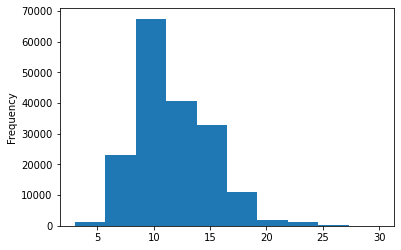

In [16]:
train_df.total_lines.plot.hist()

In [17]:
#one hot encoding 
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
train_labels_ohe = ohe.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_ohe = ohe.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_ohe = ohe.transform(test_df['target'].to_numpy().reshape(-1,1))

In [18]:
#label Encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [28]:
#mappping back to text
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

Baseline Model
Naive Bayes

In [32]:
 from sklearn.feature_extraction.text import TfidfVectorizer
 from sklearn.naive_bayes import MultinomialNB
 from sklearn.pipeline import Pipeline

#creating model
model = Pipeline([
                  ("tf",TfidfVectorizer()),
                  ("clf", MultinomialNB())


])

In [33]:
model.fit(X = train_df['text'], 
          y = train_labels_encoded)

Pipeline(steps=[('tf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [34]:
#Accuracy of model
model.score(val_df['text'], val_labels_encoded)

0.7218323844829869

In [35]:
#model predictions 
NB_pred =model.predict(val_df['text'])

In [19]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  from sklearn.metrics import accuracy_score, precision_recall_fscore_support
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [43]:
NB_results = calculate_results(val_labels_encoded, NB_pred)

In [44]:
NB_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [54]:
sen_len = []
for i in train_df["text"]:
  sen_len.append(len(i.split(" ")))

In [58]:
import numpy as np

In [62]:
#95% quantile of sentence length
np.quantile(np.array(sen_len), 0.95)
np.mean(np.array(sen_len))

26.338269273494777

Tokenizing data

In [20]:
from tensorflow.keras.layers import TextVectorization

In [21]:
#create text vectorizer 
text_vectoriser = TextVectorization(max_tokens=68000,
                                    output_mode = "int",
                                    output_sequence_length = 55


                                    )

In [22]:
#fitting vectorizer 
text_vectoriser.adapt(train_df["text"])

Simple feed forward Model

In [81]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Dropout,Embedding, Dense, LSTM, Conv1D, concatenate, Input

In [52]:
from tensorflow.keras.models import Model,Sequential

In [37]:
from tensorflow.python.distribute.distribution_strategy_context import variable_sync_on_read_context
def build_model():
  input_1 = Input(shape = (1,), dtype = tf.string)
  input_2 = Input(shape = (2, ))

  vtext = text_vectoriser(input_1)
  vtext = Embedding(68000,512)(vtext)
  vtext = Conv1D(64, 5, activation = "relu")(vtext)
  vtext = GlobalAveragePooling1D()(vtext)
  con = concatenate([input_2, vtext])

  output = Dense(128, activation = "relu")(con)
  output = Dense(5, activation = "softmax" )(output)


  model = Model(inputs = [input_1, input_2], outputs = output)

  model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
  return model



In [38]:
ff_model = build_model()

In [41]:
ff_model.fit(x =[train_df['text'], train_df[['total_lines',"line_number"]]],
             y = train_labels_encoded,epochs =5,
             validation_data = ([val_df['text'], val_df[['total_lines',"line_number"]]], val_labels_encoded))

Epoch 1/5
5627/5627 [==============================] - 48s 9ms/step - loss: 0.3263 - accuracy: 0.8803 - val_loss: 0.3102 - val_accuracy: 0.8870
Epoch 2/5
5627/5627 [==============================] - 46s 8ms/step - loss: 0.2951 - accuracy: 0.8938 - val_loss: 0.3025 - val_accuracy: 0.8913
Epoch 3/5
5627/5627 [==============================] - 46s 8ms/step - loss: 0.2785 - accuracy: 0.9024 - val_loss: 0.3147 - val_accuracy: 0.8883
Epoch 4/5
5627/5627 [==============================] - 48s 9ms/step - loss: 0.2642 - accuracy: 0.9088 - val_loss: 0.3157 - val_accuracy: 0.8858
Epoch 5/5
5627/5627 [==============================] - 46s 8ms/step - loss: 0.2506 - accuracy: 0.9154 - val_loss: 0.3375 - val_accuracy: 0.8758


In [45]:

#Feed forward predictions
ff_preds =tf.argmax(ff_model.predict([test_df['text'], test_df[['total_lines',"line_number"]]]), axis = 1)

In [46]:
#results on test data 
calculate_results(test_labels_encoded, ff_preds)


{'accuracy': 87.33698357391737,
 'f1': 0.8715814348737815,
 'precision': 0.874008180394455,
 'recall': 0.8733698357391737}

Transfer Learning, universal sentene encoder

In [49]:
import tensorflow_hub as hub

In [50]:
#download pretrained model
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                                        input_shape =[],
                                        dtype = tf.string,
                                        name = "badboy")

In [53]:
trained_emb_model = Sequential([sentence_encoder_layer,
                                ])

In [69]:
from tensorflow.python.keras.layers.pooling import GlobalMaxPooling1D
def build_model():
  input_1 = Input(shape = (), dtype = tf.string)
  input_2 = Input(shape = (2, ))

  
  vtext = trained_emb_model(input_1)
  con = concatenate([input_2, vtext])

  output = Dense(128, activation = "relu")(con)
  output = Dense(5, activation = "softmax" )(output)


  model = Model(inputs = [input_1, input_2], outputs = output)

  model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
  return model


In [70]:
tf_model = build_model()

In [71]:
tf_model.fit(x =[train_df['text'], train_df[['total_lines',"line_number"]]],
             y = train_labels_encoded,epochs =5,
             validation_data = ([val_df['text'], val_df[['total_lines',"line_number"]]], val_labels_encoded))

Epoch 1/5
5627/5627 [==============================] - 82s 14ms/step - loss: 0.4278 - accuracy: 0.8361 - val_loss: 0.3838 - val_accuracy: 0.8516
Epoch 2/5
5627/5627 [==============================] - 77s 14ms/step - loss: 0.3714 - accuracy: 0.8565 - val_loss: 0.3775 - val_accuracy: 0.8500
Epoch 3/5
5627/5627 [==============================] - 80s 14ms/step - loss: 0.3534 - accuracy: 0.8637 - val_loss: 0.3526 - val_accuracy: 0.8637
Epoch 4/5
5627/5627 [==============================] - 77s 14ms/step - loss: 0.3412 - accuracy: 0.8692 - val_loss: 0.3524 - val_accuracy: 0.8657
Epoch 5/5
5627/5627 [==============================] - 76s 14ms/step - loss: 0.3325 - accuracy: 0.8740 - val_loss: 0.3452 - val_accuracy: 0.8675


In [73]:
tf_preds =tf.argmax(tf_model.predict([test_df['text'], test_df[['total_lines',"line_number"]]]), axis = 1)

In [74]:
calculate_results(test_labels_encoded, tf_preds)

{'accuracy': 86.41114982578398,
 'f1': 0.8626788648522942,
 'precision': 0.862682222426271,
 'recall': 0.8641114982578397}

In [76]:
#making it trainable
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                                        input_shape =[],
                                        dtype = tf.string,
                                        trainable= True,
                                        name = "badboy")

In [77]:
from tensorflow.python.keras.layers.pooling import GlobalMaxPooling1D
def build_model():
  input_1 = Input(shape = (), dtype = tf.string)
  input_2 = Input(shape = (2, ))

  
  vtext = trained_emb_model(input_1)
  con = concatenate([input_2, vtext])

  output = Dense(128, activation = "relu")(con)
  output = Dense(5, activation = "softmax" )(output)


  model = Model(inputs = [input_1, input_2], outputs = output)

  model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
  return model


In [78]:
ttf_model = build_model()

In [79]:
ttf_model.fit(x =[train_df['text'], train_df[['total_lines',"line_number"]]],
             y = train_labels_encoded,epochs =5,
             validation_data = ([val_df['text'], val_df[['total_lines',"line_number"]]], val_labels_encoded))

Epoch 1/5
5627/5627 [==============================] - 80s 14ms/step - loss: 0.4322 - accuracy: 0.8343 - val_loss: 0.3860 - val_accuracy: 0.8499
Epoch 2/5
5627/5627 [==============================] - 77s 14ms/step - loss: 0.3751 - accuracy: 0.8554 - val_loss: 0.3630 - val_accuracy: 0.8616
Epoch 3/5
5627/5627 [==============================] - 78s 14ms/step - loss: 0.3561 - accuracy: 0.8636 - val_loss: 0.3546 - val_accuracy: 0.8636
Epoch 4/5
5627/5627 [==============================] - 78s 14ms/step - loss: 0.3439 - accuracy: 0.8690 - val_loss: 0.3565 - val_accuracy: 0.8643
Epoch 5/5
5627/5627 [==============================] - 80s 14ms/step - loss: 0.3345 - accuracy: 0.8733 - val_loss: 0.3450 - val_accuracy: 0.8685


In [87]:
#making it trainable
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                                        input_shape =[],
                                        dtype = tf.string,
                                        trainable= False,
                                        name = "badboy")

In [88]:
#dropout 
def build_model():
  input_1 = Input(shape = (), dtype = tf.string)
  input_2 = Input(shape = (2, ))

  
  vtext = trained_emb_model(input_1)
  con = concatenate([input_2, vtext])

  output = Dense(128, activation = "relu")(con)
  output = Dropout(0.3)(output)
  output = Dense(5, activation = "softmax" )(output)


  model = Model(inputs = [input_1, input_2], outputs = output)

  model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
  return model


In [89]:
dttf_model = build_model()

In [90]:
dttf_model.fit(x =[train_df['text'], train_df[['total_lines',"line_number"]]],
             y = train_labels_encoded,epochs =5,
             validation_data = ([val_df['text'], val_df[['total_lines',"line_number"]]], val_labels_encoded))

Epoch 1/5
5627/5627 [==============================] - 84s 15ms/step - loss: 0.4601 - accuracy: 0.8247 - val_loss: 0.3791 - val_accuracy: 0.8548
Epoch 2/5
5627/5627 [==============================] - 82s 15ms/step - loss: 0.3966 - accuracy: 0.8499 - val_loss: 0.3735 - val_accuracy: 0.8589
Epoch 3/5
5627/5627 [==============================] - 82s 14ms/step - loss: 0.3854 - accuracy: 0.8558 - val_loss: 0.3575 - val_accuracy: 0.8639
Epoch 4/5
5627/5627 [==============================] - 81s 14ms/step - loss: 0.3789 - accuracy: 0.8590 - val_loss: 0.3625 - val_accuracy: 0.8663
Epoch 5/5
5627/5627 [==============================] - 85s 15ms/step - loss: 0.3755 - accuracy: 0.8617 - val_loss: 0.3617 - val_accuracy: 0.8656


Character Embeddings 

In [109]:
#make fuction to split sentences in characters 
def split_cha(text):
  return " ".join(list(text))
import pandas as pd  
#spliting data texts into characters 
train_char = pd.Series([split_cha(text) for text in train_df['text']])
val_char = pd.Series([split_cha(text) for text in val_df['text']])
test_char  = pd.Series([split_cha(text) for text in test_df['text']])

In [110]:
#average character sentence length 
np.quantile([len(sen.split(" ")) for sen in train_char], 0.95)

342.0

In [111]:
train_char[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [120]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
len(alphabet)

68

In [122]:
#creating character vectorizer
char_vectoriser = TextVectorization(max_tokens=70,
                                    output_mode = "int",
                                    output_sequence_length = 342,


                                    )

In [155]:
#creating model 
def build_model():
  input_1 = Input(shape = (1,), dtype = tf.string)
  
  input_2 = Input(shape = (2, ))

  input_3 = Input(shape =(1,), dtype = tf.string)

  vtext = text_vectoriser(input_1)
  vtext = Embedding(68000,512)(vtext)
  vtext = Conv1D(64, 5, activation = "relu")(vtext)
  vtext = GlobalAveragePooling1D()(vtext)

  ctext = text_vectoriser(input_3)
  ctext = Embedding(28,512)(ctext)
  ctext = Conv1D(64,5,activation = "relu")(ctext)
  ctext = GlobalMaxPooling1D()(ctext)


  con = concatenate([input_2, vtext, ctext], axis = 1)
  output = Dense(64, activation = "relu")(con)

  output = Dense(5, activation = "softmax" )(output)


  model = Model(inputs = [input_1, input_2, input_3], outputs = output)

  model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
  return model

In [156]:
cff_model = build_model(
)

In [157]:
cff_model.fit(x =[train_df['text'], train_df[['total_lines',"line_number"]], train_char],
             y = train_labels_encoded,epochs =5,
             validation_data = ([val_df['text'], val_df[['total_lines',"line_number"]], val_char], val_labels_encoded))

Epoch 1/5
5627/5627 [==============================] - 58s 10ms/step - loss: 0.3739 - accuracy: 0.8618 - val_loss: 0.3144 - val_accuracy: 0.8844
Epoch 2/5
5627/5627 [==============================] - 56s 10ms/step - loss: 0.3022 - accuracy: 0.8909 - val_loss: 0.3295 - val_accuracy: 0.8822
Epoch 3/5
5627/5627 [==============================] - 55s 10ms/step - loss: 0.2837 - accuracy: 0.8986 - val_loss: 0.3126 - val_accuracy: 0.8857
Epoch 4/5
5627/5627 [==============================] - 55s 10ms/step - loss: 0.2686 - accuracy: 0.9056 - val_loss: 0.3179 - val_accuracy: 0.8850
Epoch 5/5
5627/5627 [==============================] - 55s 10ms/step - loss: 0.2551 - accuracy: 0.9115 - val_loss: 0.3176 - val_accuracy: 0.8834


In [130]:
#model prediction
cff_pred = tf.argmax(cff_model.predict([test_df['text'], test_df[['total_lines',"line_number"]], test_char]), axis = 1)

In [131]:
#model performance 
calculate_results(test_labels_encoded, cff_pred)

{'accuracy': 88.27277252364361,
 'f1': 0.8771780211084232,
 'precision': 0.889077038037158,
 'recall': 0.8827277252364361}

Adding character embeding seems to not be improving results